In [198]:
from data_cleaning import Open, Stream, MakeMIDI, ChordEval
from music21 import chord, note, stream, clef, meter
import os
import numpy as np
import torch

In [2]:
mid_file1 = os.path.join(os.getcwd(), "progression1.mid")
midi_data1 = Open.open_midi(mid_file1)
mid_file2 = os.path.join(os.getcwd(), "progression2.mid")
midi_data2 = Open.open_midi(mid_file2)

In [24]:
mid_file_offset = os.path.join(os.getcwd(), "offset chord.mid")
midi_data_offset = Open.open_midi(mid_file_offset)

In [3]:
concatenated_array = []

In [5]:
for i, part in enumerate(midi_data2.parts):
    for element in part.recurse():
        if isinstance(element, chord.Chord):
            concatenated_array.append(element)

In [6]:
all_chords = []
for chord in concatenated_array:
    chord_arr = []
    for notes in chord:
        chord_arr.append(notes.pitch.ps)
    all_chords.append(chord_arr)

In [7]:
len(all_chords)

186

In [9]:
print(max(len(chord) for chord in all_chords))
print(min(len(chord) for chord in all_chords))

6
3


In [10]:
N = torch.zeros((129, 129), dtype=torch.int32)

In [11]:
flattened_list = [int(element) for sublist in all_chords for element in sublist]

In [12]:
notes = sorted(set(flattened_list))

In [13]:
len(notes)

23

In [14]:
n_to_i = {s: s for i, s in enumerate(notes)}
n_to_i["."] = 128

In [217]:
i_to_n = {}

for n in notes:
    n_temp = note.Note(n)
    i_to_n[n] = n_temp.nameWithOctave

i_to_n[128] = "."
print(i_to_n)

{36: 'C2', 40: 'E2', 41: 'F2', 43: 'G2', 45: 'A2', 47: 'B2', 48: 'C3', 50: 'D3', 52: 'E3', 53: 'F3', 55: 'G3', 57: 'A3', 58: 'B-3', 59: 'B3', 60: 'C4', 62: 'D4', 63: 'E-4', 64: 'E4', 65: 'F4', 67: 'G4', 69: 'A4', 71: 'B4', 72: 'C5', 128: '.'}


In [16]:
n_to_i, i_to_n

({36: 36,
  40: 40,
  41: 41,
  43: 43,
  45: 45,
  47: 47,
  48: 48,
  50: 50,
  52: 52,
  53: 53,
  55: 55,
  57: 57,
  58: 58,
  59: 59,
  60: 60,
  62: 62,
  63: 63,
  64: 64,
  65: 65,
  67: 67,
  69: 69,
  71: 71,
  72: 72,
  '.': 128},
 {36: 'C2',
  40: 'E2',
  41: 'F2',
  43: 'G2',
  45: 'A2',
  47: 'B2',
  48: 'C3',
  50: 'D3',
  52: 'E3',
  53: 'F3',
  55: 'G3',
  57: 'A3',
  58: 'B-3',
  59: 'B3',
  60: 'C4',
  62: 'D4',
  63: 'E-4',
  64: 'E4',
  65: 'F4',
  67: 'G4',
  69: 'A4',
  71: 'B4',
  72: 'C5',
  128: '.'})

In [18]:
for chord in all_chords:
    c_bigram = ["."] + chord + ["."]
    for c1, c2 in zip(c_bigram, c_bigram[1:]):
        ix1 = n_to_i[c1]
        ix2 = n_to_i[c2]
        N[ix1, ix2] += 1

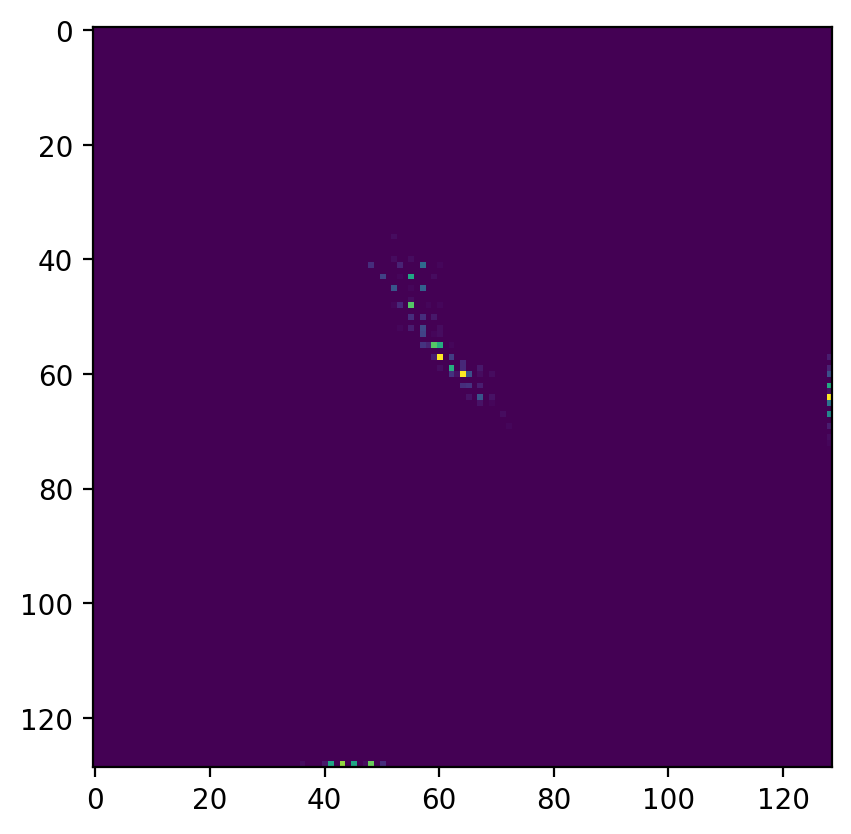

In [19]:
import matplotlib.pyplot as plt

plt.imshow(N)

# Sample the probabilities


In [144]:
P = N.float()
P /= P.sum(1, keepdim=True)

In [30]:
g = torch.Generator().manual_seed(57485)
midi_n = 0
numofc = 0
while True:
    p = P[midi_n]
    if not torch.isnan(p).any().item():
        midi_n = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()
        if not midi_n == 128:
            new_note = note.Note(midi_n)
            print(new_note.pitch)
    else:
        midi_n += 1
    if midi_n == 128:
        print("__")
        numofc += 1
        if numofc == 4:
            break

E3
A3
C4
F4
__
C3
G3
C4
E4
__
A2
A3
C4
D4
__
F2
A3
__


# Evaluating the Quality of the model


In [133]:
log_likelihood = 0.0
n = 0
for chord in all_chords:
    c_bigram = ["."] + chord + ["."]
    for c1, c2 in zip(c_bigram, c_bigram[1:]):
        ix1 = n_to_i[c1]
        ix2 = n_to_i[c2]
        p = P[ix1, ix2]
        logprob = torch.log(p)
        log_likelihood += logprob
        n += 1

nll = -log_likelihood
# nll/=n
print(nll / n)

tensor(1.0509)


# Making a Neural Network


## Creating a training set


In [145]:
xs, ys = [], []

for c in all_chords:
    ns = ["."] + c + ["."]
    for n1, n2 in zip(ns, ns[1:]):
        ix1 = n_to_i[n1]
        ix2 = n_to_i[n2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
length_xs = xs.nelement()

g = torch.Generator().manual_seed(547648569)
W = torch.randn((129, 129), generator=g, requires_grad=True)

In [135]:
(W**2).mean()

tensor(1.0002, grad_fn=<MeanBackward0>)

## One Hot Encoding


In [146]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=129).float()
yenc = F.one_hot(ys, num_classes=129).float()

In [78]:
xenc, yenc

(tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]))

## Back Propogation


In [112]:
from tqdm import tqdm

In [210]:
loss = 0.0
for k in tqdm(range(100000), desc="Backpropagation : "):
    xenc = F.one_hot(xs, num_classes=129).float()
    logits = xenc @ W
    # Softmax
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(length_xs), ys].log().mean()

    # Backward Pass
    W.grad = None
    loss.backward()

    # Modify Weight
    W.data += -0.1*W.grad
print(loss.item())

Backpropagation : 100%|██████████| 100000/100000 [01:34<00:00, 1061.89it/s]

1.0534700155258179


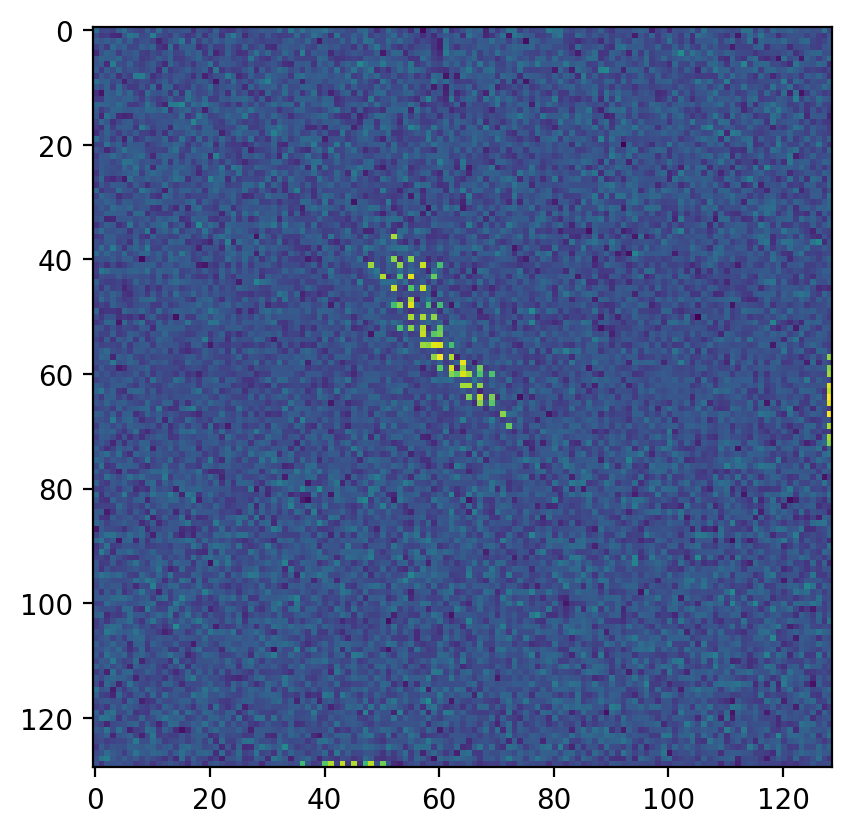

In [211]:
W_detached = W.detach().numpy()
plt.imshow(W_detached)

# Sample from Neural Network


In [219]:
g = torch.Generator().manual_seed(840283515)
final_progression = []

for i in range(4):
    out = []
    ix = 0

    while True:
        xenc_local = F.one_hot(torch.tensor([ix]), num_classes=129).float()
        logits = xenc_local @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

        if ix == 128:
            break
        try:
            out.append(i_to_n[ix])
        except KeyError:
            print("index doesn't exist moving on!")
    final_progression.append(out)
print(final_progression)

index doesn't exist moving on!
index doesn't exist moving on!
index doesn't exist moving on!
index doesn't exist moving on!
index doesn't exist moving on!
[['E3', 'A3', 'C4'], ['D3', 'A3', 'C4'], ['A2', 'A3', 'C4', 'E4', 'G4'], ['A4']]


In [213]:
final_progression

[[104, 111, 52, 57, 60], [37, 50, 57, 60], [73, 45, 57, 60, 64, 67], [61, 69]]

# Finding all types of elements in a part


In [22]:
for part in midi_data_offset.parts:
    chords_array = []
    for idx, element in enumerate(part.recurse()):
        if isinstance(element, stream.Measure):
            print(idx, element)
        elif isinstance(element, clef.TrebleClef):
            print(idx, element)
        elif isinstance(element, meter.TimeSignature):
            print(idx, element)
        elif isinstance(element, chord.Chord):
            print(
                "CHord",
                [
                    [
                        n.pitch.ps,
                        n.volume.velocity,
                        n.duration.quarterLength,
                        n.duration.type,
                        n.offset,
                    ]
                    for n in element.notes
                ],
            )
        elif isinstance(element, note.Rest):
            print(idx, element)

0 <music21.stream.Measure 1 offset=0.0>
2 <music21.clef.TrebleClef>
3 <music21.meter.TimeSignature 4/4>
CHord [[60.0, 102, 1.0, 'quarter', 0.0], [65.0, 102, 1.0, 'quarter', 0.0]]
5 <music21.stream.Measure 2 offset=4.0>
6 <music21.note.Rest quarter>
CHord [[60.0, 100, 1.0, 'quarter', 0.0], [67.0, 102, 1.0, 'quarter', 0.0]]
8 <music21.note.Rest dotted-eighth>


In [184]:
for i, part in enumerate(midi_data_offset.parts):
    chords_array = []
    for idx, element in enumerate(part.recurse()):
        print(idx, element)
        if isinstance(element, chord.Chord):
            # if isinstance(part.recurse()[idx-1],)
            chord_array = [element]
            # for i, n in enumerate(element):
            #     chord_array.append(
            #         [int(n.pitch.ps), n.volume.velocity, n.duration.quarterLength, n.offset, 0])
            chords_array.append(chord_array)
    if chords_array:
        concatenated_array.append(chords_array)

0 <music21.stream.Measure 1 offset=0.0>
1 
2 <music21.clef.TrebleClef>
3 <music21.meter.TimeSignature 4/4>
4 <music21.chord.Chord C4 F4>
5 <music21.stream.Measure 2 offset=4.0>
6 <music21.note.Rest quarter>
7 <music21.chord.Chord C4 G4>
8 <music21.note.Rest dotted-eighth>
9 <music21.bar.Barline type=final>


In [185]:
concatenated_array

[[[<music21.chord.Chord C4 F4>], [<music21.chord.Chord C4 G4>]]]

# Outputting a MIDI file


In [220]:
s = stream.Score()

In [221]:
for chord_array in final_progression:
    c = chord.Chord(chord_array)
    print(c)
    s.append(c)

<music21.chord.Chord E3 A3 C4>
<music21.chord.Chord D3 A3 C4>
<music21.chord.Chord A2 A3 C4 E4 G4>
<music21.chord.Chord A4>


In [166]:
for each_file in concatenated_array:
    for chords in each_file:
        chord_arr = []
        for each_chord in chords:
            n = note.Note(each_chord[0])
            n.volume.velocity = each_chord[1]
            n.duration.quarterLength = each_chord[2]
            n.offset = each_chord[3]
            chord_arr.append(n)

        c = chord.Chord(chord_arr)
        s.append(c)

In [167]:
s

<music21.stream.Score 0x1ef6dc803d0>

In [222]:
s.write("midi", "output_file.mid")

'output_file.mid'